In [1]:
import json
from dateutil import parser
import TweetExtraction as te
import pandas as pd
import DataProcessing as dp
import statsmodels.api as sm
from statsmodels.api import families
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from statsmodels.stats.diagnostic import het_white
from datetime import datetime as dt
import random as rnd
from statsmodels.discrete.count_model import NegativeBinomialP, ZeroInflatedNegativeBinomialP
from statsmodels.api import OLS
from statsmodels.tools import add_constant
import seaborn as sb
from sklearn.decomposition import PCA

chunk_files = [
    './data/id_chunk0.jsonl', 
    './data/id_chunk1.jsonl', 
    './data/id_chunk2.jsonl', 
    './data/id_chunk3.jsonl', 
    './data/id_chunk4.jsonl',
    './data/id_chunk_comp0.jsonl',
    './data/id_chunk_comp1.jsonl',
    './data/id_chunk_comp2.jsonl',
    './data/id_chunk_comp3.jsonl',
    './data/id_chunk_comp4.jsonl',
    './data/id_chunk_comp5.jsonl',
    './data/id_chunk_comp6.jsonl',
    './data/id_chunk_comp7.jsonl',
    './data/id_chunk_comp8.jsonl',
    './data/id_chunk_comp9.jsonl'
]

In [2]:
# tweets_df = te.get_all_tweets(chunk_files)
# tweets_df.to_pickle('./tweets.pkl')
# combined_df = dp.merge_preprocess_climate_tweets(
#     './data/climateTweets.csv',
#     './tweets.pkl',
#     retweets=False
# )
# combined_df.to_pickle('combined_tweets.pkl')

In [2]:
def transformations(df):

    new_df = df.copy()

    new_df['log_text_len'] = new_df['text'].map(lambda x: np.log(len(x) + 1))
    new_df['text_len'] = new_df['text'].map(lambda x: len(x))
    
    new_df['log_user_followers'] = np.log(new_df['user_followers'] + 1)
    new_df['log_user_favorites'] = np.log(new_df['user_favorites'] + 1)
    new_df['log_user_friends'] = np.log(new_df['user_friends'] + 1)
    new_df['log_user_freq'] = np.log(new_df['user_freq'] + 1)
    new_df['bool_user_verified'] = new_df['user_verified'].map(lambda x: int(x == True))

    new_df['bool_hashtags'] = new_df['hashtags'].map(lambda x: int(x > 0))
    new_df['bool_mentions'] = new_df['mentions'].map(lambda x: int(x > 0))
    new_df['bool_urls'] = new_df['urls'].map(lambda x: int(x > 0))
    new_df['bool_media'] = new_df['media'].map(lambda x: int(x > 0))
    
    new_df['bool_sensitive'] = new_df['sensitive'].map(lambda x: int(x == True))
    new_df['bool_aggressive'] = new_df['aggressive']
    new_df['denier']

    new_df['bool_retweets'] = new_df['retweets'].map(lambda x: int(x > 0))
    new_df['log_retweets'] = new_df['retweets'].map(lambda x: np.log(x + 1))

    new_df['bool_favorites'] = new_df['favorites'].map(lambda x: int(x > 0))
    new_df['log_favorites'] = new_df['favorites'].map(lambda x: np.log(x + 1))

    new_df['emotionality'] = new_df['sentiment'].map(lambda x: np.abs(x))
    new_df['bool_sentiment'] = new_df['sentiment'].map(lambda x: int(x > 0))
    new_df['log_sentiment'] = new_df['sentiment'].map(lambda x: np.log(x + 1))

    new_df['bool_awareness'] = new_df['topic'].map(lambda x: int(x == 'Awareness'))
    new_df['bool_consumption'] = new_df['topic'].map(lambda x: int(x == 'Consumption'))
    new_df['bool_emissions'] = new_df['topic'].map(lambda x: int(x == 'Emissions'))
    new_df['bool_global'] = new_df['topic'].map(lambda x: int(x == 'Global'))
    new_df['bool_ideology'] = new_df['topic'].map(lambda x: int(x == 'Ideology'))
    new_df['bool_intervention'] = new_df['topic'].map(lambda x: int(x == 'Intervention'))
    new_df['bool_politics'] = new_df['topic'].map(lambda x: int(x == 'Politics'))
    new_df['bool_trump'] = new_df['topic'].map(lambda x: int(x == 'Trump'))
    new_df['bool_undefined'] = new_df['topic'].map(lambda x: int(x == 'Undefined'))
    new_df['bool_weather'] = new_df['topic'].map(lambda x: int(x == 'Weather'))

    return new_df

In [3]:
combined_df = pd.read_pickle('combined_tweets.pkl').drop_duplicates()

In [4]:
translated_df = transformations(combined_df)

In [17]:
with pd.option_context('display.max_colwidth', None):
    display(translated_df[translated_df['bool_awareness'] == 1][['text']].sample(5))

,text
2134457,Less than a third of Americans believe global warming poses an imminent threat to the U. S. https://t.co/QxmPMIBlLh
7297210,https://t.co/5nlKWnGKsl #savevoiforest save voi forest for posterity &amp; climate change is real @UNEP @JudyWakhungu @paulakahumbu #savetsavo
1973744,"@Hettindi @poeetweet nee dat was het rare, research geeft al mini ijstijd aan jaren geleden, door global warming merken we nie zoveel van"
1860353,It's International Polar Bear Day. Raise awareness for their habitat loss @hellogiggles http://t.co/iCyIsDSWSo #PolarBearDay #globalwarming
5770630,Lets us all prepare ourselves against global warming. Let us all install air conditioners in our homes. Victory will be ours and only ours.


In [6]:
user_predictors = [
    'log_user_followers', 'bool_user_verified', 'log_user_friends', 'log_user_freq', 'log_user_favorites'
]
structural_predictors = [
    'bool_hashtags', 'bool_mentions', 'bool_urls', 'bool_media', 'bool_sensitive', 'log_text_len'
]
content_predictors = [
    'sentiment', 'bool_aggressive'
]
framing_predictors = [
    'bool_awareness', 'bool_consumption', 'bool_emissions', 'bool_global', 
    'bool_ideology', 'bool_intervention', 'bool_politics', 'bool_trump', 
    'bool_weather'
]
numeric_predictors = user_predictors + structural_predictors + content_predictors + framing_predictors

## Descriptive Data Analysis

In [7]:
hashtagless = translated_df[translated_df['bool_hashtags'] == 0]
keyword_filter = hashtagless['text'].map(lambda x: 'climate change' in x.lower() or 'global warming' in x.lower() or 'climate hoax' in x.lower())
with pd.option_context('display.max_colwidth', None):
    display(hashtagless[~keyword_filter][['text']])

,text
1227,@Lid79908481's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.
2093,"It's happening right now, not very far! a few hours by plane from home! #poverty#climatechange#UN#refugee#asia#humantight#climate#chine#usa# https://t.co/6fuXIw0gVd"
5636,窓が割れるので東急はクソ
6161,@na_co_UoxoU @Candy みんなにはほよりとかほよとかほよちゃんとかって呼ばれるよ🤟🏻\n呼びやすいように呼んでもらえれば( ᐡ｡› ·̫ ‹｡ᐡ )♡
6187,@Pamela_moreiraa @netopaodequeijo @mnnau_ ta
...,...
7672654,#irma#climatechange\nRead Isaiah ch24\nThe Lord's devastation of the earth\nHe will lay it waste &amp; it will affect ALL\nas all bear guilt ......
7674988,"Fascinating : ""Where is the remotest place on earth?"" http://bit.ly/O2yQ6 #ecology#climatechange#environment"
7676079,@Peston So if the US gets its trade deal and the NHS is privatised how does that help the working class Robert?
7677817,Every Argument Against Veganism | Ed Winters | TEDxBathUniversity https://t.co/NeDuHXnOkb via @YouTube #meat#dairy#vegan#animals#health#awareness#bethechange#climatechange#gogreen#environmental#love#earthlinged#amazing#food#ethical#hearthealth#cancerawareness


In [8]:
np.round(translated_df['topic'].value_counts() / len(translated_df), 2)

Global          0.25
Weather         0.19
Intervention    0.15
Undefined       0.11
Politics        0.09
Trump           0.07
Emissions       0.07
Ideology        0.04
Consumption     0.03
Awareness       0.02
Name: topic, dtype: float64

In [9]:
len(translated_df[translated_df['bool_retweets'] == 0]) / len(translated_df)

0.8068691348272744

In [10]:
with pd.option_context('display.max_columns', None, 'display.float_format', '{:20,.2f}'.format):
    display(translated_df[['retweets']].describe())

,retweets
count,"7,641,399.00"
mean,1.82
std,118.83
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,"149,655.00"


In [12]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(translated_df['retweets'].sample(100000).to_numpy())

0.9570029526490783

## Principle Component Analysis

In [15]:
denier_df = translated_df[translated_df['denier'] == 1]
believer_df = translated_df[translated_df['denier'] == 0]

awareness_df = translated_df[translated_df['bool_awareness'] == 1]
politics_df = translated_df[translated_df['bool_politics'] == 1]
intervention_df = translated_df[translated_df['bool_intervention'] == 1]

In [24]:
translated_df['topic']

0              Politics
1             Undefined
2              Ideology
3               Weather
4          Intervention
               ...     
7683715        Politics
7683716       Awareness
7683717          Global
7683718    Intervention
7683719        Politics
Name: topic, Length: 7641399, dtype: object

In [58]:
counts = translated_df.groupby(['month', 'topic']).agg({'id': 'count'})
totals = translated_df.groupby('month').agg({'id': 'count'})

for row in counts.iterrows():
    counts.loc[row[0]] = counts.loc[row[0]] / totals.loc[row[0][0]]

df = translated_df[['month', 'topic']].sort_values(['month', 'topic']).drop_duplicates()
df['prop'] = counts['id'].values

In [84]:
df = translated_df[['month'] + framing_predictors].groupby('month').agg({t:'sum' for t in framing_predictors})
df['total'] = df[framing_predictors].sum(axis=1)

for t in framing_predictors:
    df[t] = df[t] / df['total']

df['month'] = df.index

del df['total']

In [100]:
df

,bool_awareness,bool_consumption,bool_emissions,bool_global,bool_ideology,bool_intervention,bool_politics,bool_trump,bool_weather,month
month,,,,,,,,,,
2006-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006-06-01
2006-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006-08-01
2006-11-01,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,2006-11-01
2006-12-01,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.750000,2006-12-01
2007-01-01,0.022727,0.022727,0.000000,0.431818,0.000000,0.181818,0.022727,0.022727,0.295455,2007-01-01
...,...,...,...,...,...,...,...,...,...,...
2019-06-01,0.025131,0.013613,0.038743,0.325654,0.041885,0.216754,0.138220,0.053403,0.146597,2019-06-01
2019-07-01,0.025751,0.025751,0.054077,0.315880,0.033476,0.159657,0.145923,0.055794,0.183691,2019-07-01
2019-08-01,0.027808,0.036532,0.034896,0.290076,0.022901,0.170120,0.140676,0.091603,0.185387,2019-08-01


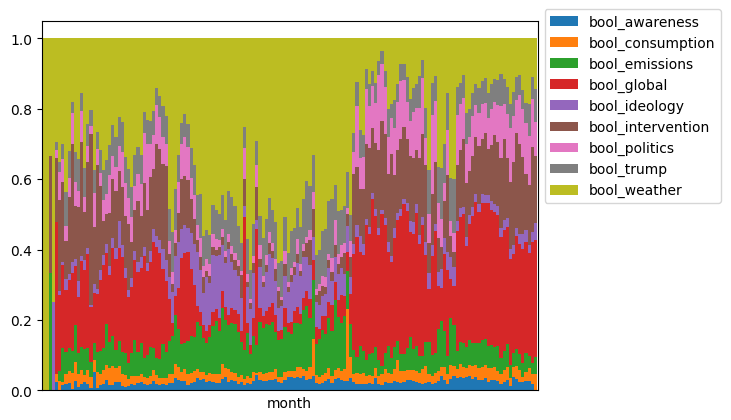

In [99]:
df.plot(x='month', kind='bar', stacked=True, width=1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_28537/3853526654.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(df.columns)


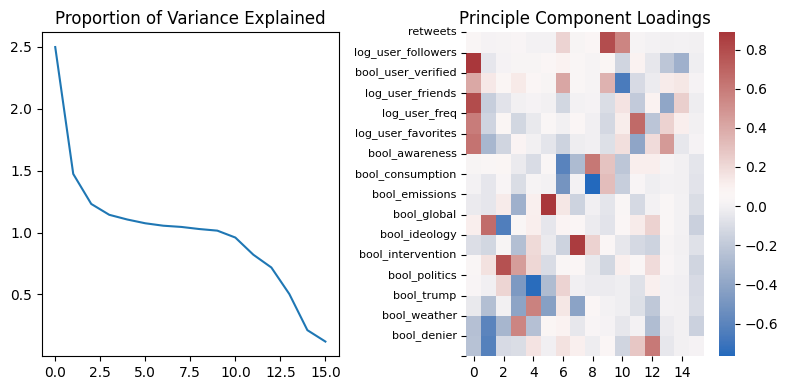

In [22]:
def pca_analysis(df):

    temp_df = df.copy()
    temp_df = temp_df.apply(lambda x: (x - x.mean()) / x.std())

    pca = PCA(n_components=len(df.columns))
    pca.fit(temp_df)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    comps = np.linspace(0,len(df.columns) - 1,len(df.columns))
    exp_var = [pca.explained_variance_[int(comp)] for comp in comps]
    axes[0].plot(comps, exp_var)
    axes[0].set_title('Proportion of Variance Explained')

    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
    loadings.index = df.columns

    sb.heatmap(loadings, ax=axes[1], cmap=sb.color_palette("vlag", as_cmap=True))
    axes[1].set_title('Principle Component Loadings')
    axes[1].tick_params(axis='y', which='major', labelsize=8)
    axes[1].yaxis.set_major_locator(plt.MaxNLocator(len(df.columns)))
    axes[1].set_yticklabels(df.columns)

    plt.tight_layout()

    plt.show()

pca_analysis(translated_df[["retweets"] + numeric_predictors + ['bool_denier']])

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_28537/3853526654.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(df.columns)


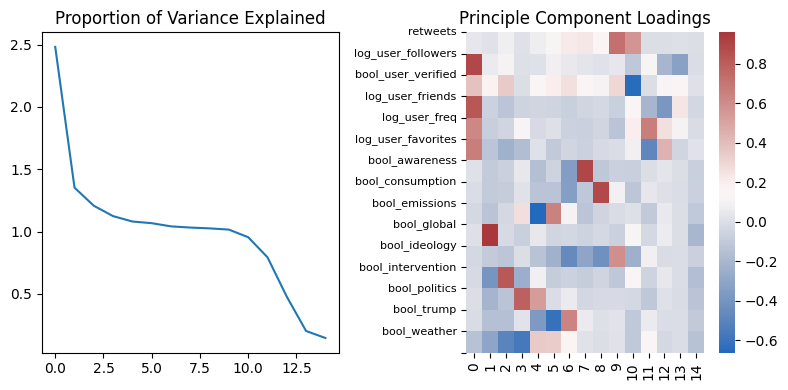

In [23]:
pca_analysis(believer_df[["retweets"] + numeric_predictors])

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_28537/3853526654.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(df.columns)


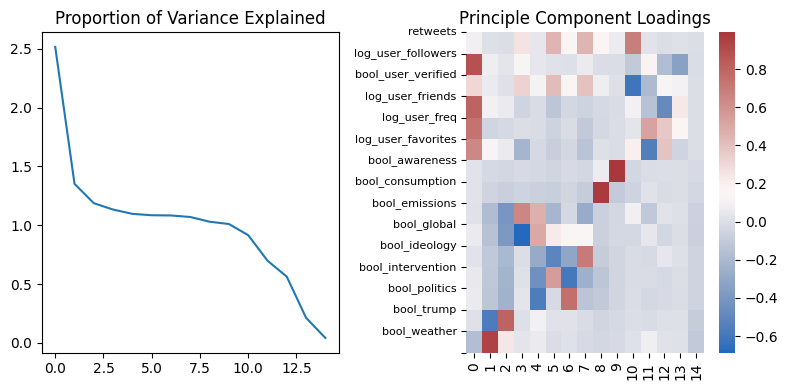

In [24]:
pca_analysis(denier_df[["retweets"] + numeric_predictors])

## Modeling

In [10]:
# equation = f"retweets ~ {' + '.join(numeric_predictors)}"
# # alpha estimation
# lambda_model = sm.glm(
#     equation,
#     data = translated_df,
#     family=families.Poisson()
# ).fit()

# translated_df['lambdas'] = lambda_model.mu
# translated_df['dependent'] = translated_df.apply(lambda x: ((x['retweets'] - x['lambdas'])**2 - x['lambdas']) / x['lambdas'], axis=1)

# alpha_model = sm.ols(
#     "dependent ~ lambdas - 1",
#     data=translated_df
# ).fit()

# print(alpha_model.params)

# model = sm.glm(equation, data=translated_df, family=families.NegativeBinomial(alpha=120.223555)).fit()
# print(model.summary())

In [52]:
ols_model = OLS(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors]),
).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     624.4
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:04:52   Log-Likelihood:            -4.7344e+07
No. Observations:             7641399   AIC:                         9.469e+07
Df Residuals:                 7641375   BIC:                         9.469e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.7406      0

In [53]:
pois_model = Poisson(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors]),
).fit_regularized()
print(pois_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.379057234326717
            Iterations: 77
            Function evaluations: 84
            Gradient evaluations: 77
                          Poisson Regression Results                          
Dep. Variable:               retweets   No. Observations:              7641399
Model:                        Poisson   Df Residuals:                  7641375
Method:                           MLE   Df Model:                           23
Date:                Thu, 12 Jan 2023   Pseudo R-squ.:                  0.4847
Time:                        17:05:37   Log-Likelihood:            -3.3462e+07
converged:                       True   LL-Null:                   -6.4941e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [7]:
nb_model = NegativeBinomialP(
    endog=translated_df['retweets'],
    exog=add_constant(translated_df[numeric_predictors + ['bool_denier']]),
).fit_regularized()
print(nb_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8223239970454949
            Iterations: 168
            Function evaluations: 170
            Gradient evaluations: 168


/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     NegativeBinomialP Regression Results                     
Dep. Variable:               retweets   No. Observations:              7641399
Model:              NegativeBinomialP   Df Residuals:                  7641375
Method:                           MLE   Df Model:                           23
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                  0.1453
Time:                        21:04:05   Log-Likelihood:            -6.2837e+06
converged:                       True   LL-Null:                   -7.3522e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.0012      0.015   -592.055      0.000      -9.031      -8.971
log_user_followers     0.7016      0.001    809.215      0.000       0.700       0.703
bool_user_verified  

In [8]:
denier_model = NegativeBinomialP(
    endog=denier_df['retweets'],
    exog=add_constant(denier_df[numeric_predictors]),
).fit_regularized()
print(denier_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5114881287958045
            Iterations: 175
            Function evaluations: 179
            Gradient evaluations: 175


/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


                     NegativeBinomialP Regression Results                     
Dep. Variable:               retweets   No. Observations:               702431
Model:              NegativeBinomialP   Df Residuals:                   702408
Method:                           MLE   Df Model:                           22
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                  0.1444
Time:                        21:04:42   Log-Likelihood:            -3.5929e+05
converged:                       True   LL-Null:                   -4.1990e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.8466      0.064   -153.915      0.000      -9.972      -9.721
log_user_followers     0.6729      0.004    189.093      0.000       0.666       0.680
bool_user_verified  

In [9]:
believer_model = NegativeBinomialP(
    endog=believer_df['retweets'],
    exog=add_constant(believer_df[numeric_predictors]),
).fit_regularized()
print(believer_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9689493121744116
            Iterations: 164
            Function evaluations: 167
            Gradient evaluations: 164


/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3121: RuntimeWarning: invalid value encountered in subtract
  llf = (gammaln(y + a1) - gammaln(y + 1) - gammaln(a1) +
/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


                     NegativeBinomialP Regression Results                     
Dep. Variable:               retweets   No. Observations:              4875105
Model:              NegativeBinomialP   Df Residuals:                  4875082
Method:                           MLE   Df Model:                           22
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                  0.1405
Time:                        21:08:48   Log-Likelihood:            -4.7237e+06
converged:                       True   LL-Null:                   -5.4959e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.9358      0.018   -483.937      0.000      -8.972      -8.900
log_user_followers     0.7205      0.001    701.646      0.000       0.718       0.722
bool_user_verified  

In [13]:
def interpret_results(bool_predictors, model):

    mean_retweets = translated_df['retweets'].mean()

    for var in bool_predictors:
        print(f"{var}:")
        multiplier = np.exp(model.params[var])
        if 'bool' in var and not var == 'bool_denier':
            false_avg = translated_df[translated_df[var] == 0]['retweets'].mean()
            true_avg = translated_df[translated_df[var] == 1]['retweets'].mean()
            print(f"false avg: {false_avg:.2f}, true avg: {true_avg:.2f}, multiplier: {multiplier:.4f}, E(diff): {(false_avg * (multiplier - 1)):.2f}", end="\n\n")
        elif 'log' in var:
            mod_multiplier = multiplier * (np.log(2) - np.log(1))
            print(f"multiplier: {multiplier:.4f}, E(diff): {mean_retweets * (mod_multiplier - 1):.2f}", end="\n\n")
        else:
            print(f"multiplier: {multiplier:.4f}, E(diff): {(mean_retweets * (multiplier - 1)):.2f}", end="\n\n")

interpret_results(numeric_predictors, nb_model)

log_user_followers:
multiplier: 2.0170, E(diff): 0.73

bool_user_verified:
false avg: 0.84, true avg: 16.73, multiplier: 1.2663, E(diff): 0.22

log_user_friends:
multiplier: 0.8156, E(diff): -0.79

log_user_freq:
multiplier: 0.5337, E(diff): -1.15

log_user_favorites:
multiplier: 1.2095, E(diff): -0.29

bool_hashtags:
false avg: 1.81, true avg: 1.84, multiplier: 1.2511, E(diff): 0.46

bool_mentions:
false avg: 2.24, true avg: 1.13, multiplier: 0.6249, E(diff): -0.84

bool_urls:
false avg: 1.83, true avg: 1.82, multiplier: 0.7863, E(diff): -0.39

bool_media:
false avg: 1.36, true avg: 4.36, multiplier: 1.9539, E(diff): 1.29

bool_sensitive:
false avg: 1.83, true avg: 0.81, multiplier: 0.7790, E(diff): -0.40

log_text_len:
multiplier: 2.3152, E(diff): 1.10

sentiment:
multiplier: 0.7511, E(diff): -0.45

bool_aggressive:
false avg: 1.55, true avg: 2.36, multiplier: 1.3118, E(diff): 0.48

bool_awareness:
false avg: 1.79, true avg: 3.33, multiplier: 2.3836, E(diff): 2.47

bool_consumption:


In [14]:
interpret_results(['bool_denier'], nb_model)

bool_denier:
multiplier: 0.6207, E(diff): -0.69



In [12]:
interpret_results(numeric_predictors, denier_model)

log_user_followers:
multiplier: 1.9600, E(diff): 0.65

bool_user_verified:
false avg: 0.84, true avg: 16.73, multiplier: 1.5281, E(diff): 0.44

log_user_friends:
multiplier: 0.8661, E(diff): -0.73

log_user_freq:
multiplier: 0.6821, E(diff): -0.96

log_user_favorites:
multiplier: 1.1311, E(diff): -0.39

bool_hashtags:
false avg: 1.81, true avg: 1.84, multiplier: 1.4430, E(diff): 0.80

bool_mentions:
false avg: 2.24, true avg: 1.13, multiplier: 0.6273, E(diff): -0.83

bool_urls:
false avg: 1.83, true avg: 1.82, multiplier: 1.3792, E(diff): 0.69

bool_media:
false avg: 1.36, true avg: 4.36, multiplier: 3.0074, E(diff): 2.72

bool_sensitive:
false avg: 1.83, true avg: 0.81, multiplier: 0.6454, E(diff): -0.65

log_text_len:
multiplier: 2.1881, E(diff): 0.94

sentiment:
multiplier: 0.8941, E(diff): -0.19

bool_aggressive:
false avg: 1.55, true avg: 2.36, multiplier: 1.2700, E(diff): 0.42

bool_awareness:
false avg: 1.79, true avg: 3.33, multiplier: 1.3823, E(diff): 0.68

bool_consumption:
f

In [11]:
interpret_results(numeric_predictors, believer_model)

log_user_followers:
multiplier: 2.0554, E(diff): 0.77

bool_user_verified:
false avg: 0.84, true avg: 16.73, multiplier: 1.2702, E(diff): 0.23

log_user_friends:
multiplier: 0.8221, E(diff): -0.78

log_user_freq:
multiplier: 0.4923, E(diff): -1.20

log_user_favorites:
multiplier: 1.2098, E(diff): -0.29

bool_hashtags:
false avg: 1.81, true avg: 1.84, multiplier: 1.1838, E(diff): 0.33

bool_mentions:
false avg: 2.24, true avg: 1.13, multiplier: 0.6619, E(diff): -0.76

bool_urls:
false avg: 1.83, true avg: 1.82, multiplier: 0.7111, E(diff): -0.53

bool_media:
false avg: 1.36, true avg: 4.36, multiplier: 1.7646, E(diff): 1.04

bool_sensitive:
false avg: 1.83, true avg: 0.81, multiplier: 0.7781, E(diff): -0.41

log_text_len:
multiplier: 2.3190, E(diff): 1.11

sentiment:
multiplier: 0.7218, E(diff): -0.51

bool_aggressive:
false avg: 1.55, true avg: 2.36, multiplier: 1.2922, E(diff): 0.45

bool_awareness:
false avg: 1.79, true avg: 3.33, multiplier: 2.5014, E(diff): 2.68

bool_consumption:


## Validation

### Check for retweet distribtuion

<AxesSubplot: >

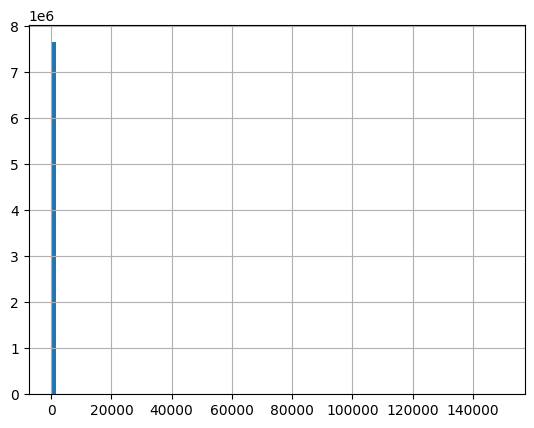

In [7]:
translated_df['retweets'].hist(bins=100)

<AxesSubplot: >

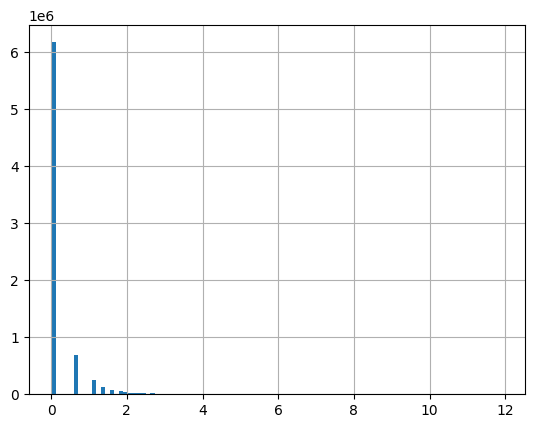

In [8]:
translated_df['log_retweets'].hist(bins=100)

### Check for predictor normality

In [16]:
viral_retweets = translated_df['retweets'].quantile(.9999)
viral_favorites = translated_df['favorites'].quantile(.99)
print(f"A tweet needs {viral_retweets} retweets to be in the 99th percentile")
print(f"A tweet needs {viral_favorites} likes to be in the 99th percentile")

A tweet needs 1196.7203999981284 retweets to be in the 99th percentile
A tweet needs 30.0 likes to be in the 99th percentile


In [24]:
translated_df['retweets'].sort_values().tail(1000).mean() * np.exp(1) - translated_df['retweets'].sort_values().tail(1000).mean()

6972.098628873593

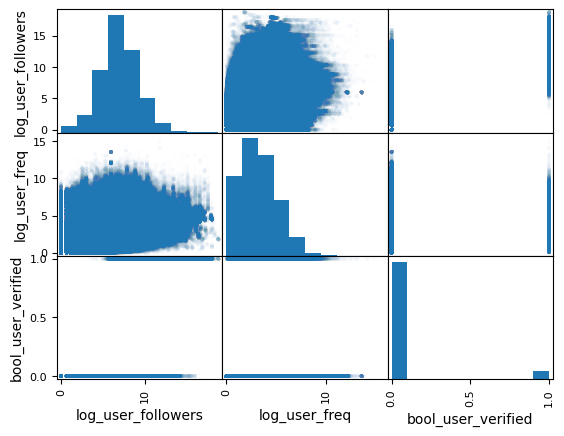

In [45]:
pd.plotting.scatter_matrix(translated_df[user_predictors], alpha=.01)
plt.show()

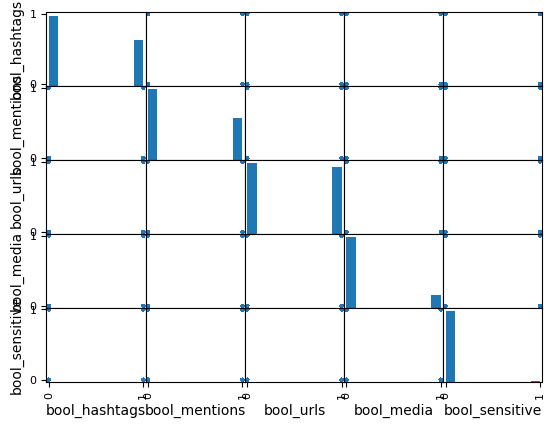

In [43]:
pd.plotting.scatter_matrix(translated_df[structural_predictors], alpha=.01)
plt.show()

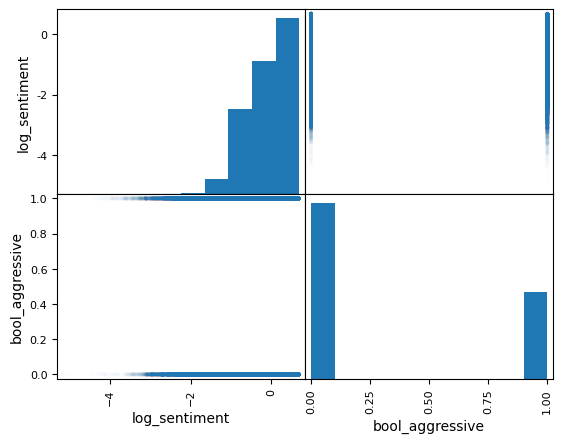

In [17]:
pd.plotting.scatter_matrix(translated_df[content_predictors], alpha=.01)
plt.show()

### Check for multicollinearity

In [15]:
translated_df[numeric_predictors + ['retweets']].corr().style.background_gradient(cmap='viridis')

,log_user_followers,bool_user_verified,log_user_friends,log_user_freq,log_user_favorites,bool_hashtags,bool_mentions,bool_urls,bool_media,bool_sensitive,log_text_len,sentiment,bool_aggressive,bool_awareness,bool_consumption,bool_emissions,bool_global,bool_ideology,bool_intervention,bool_politics,bool_trump,bool_weather,retweets
log_user_followers,1.000000,0.426491,0.659414,0.498846,0.396398,0.181751,-0.046514,0.200911,0.270182,-0.007746,0.132978,0.078661,-0.053345,0.007670,-0.006759,-0.007839,0.051392,-0.052430,0.026873,-0.001708,-0.032394,-0.143320,0.030771
bool_user_verified,0.426491,1.000000,0.102524,0.060092,0.096567,0.030278,-0.004053,0.079043,0.114148,-0.013681,0.059581,0.032894,-0.013932,-0.003143,-0.010427,-0.008937,0.067264,-0.033042,0.049823,0.014532,-0.017067,-0.066770,0.032185
log_user_friends,0.659414,0.102524,1.000000,0.314958,0.525655,0.194217,0.039887,0.144479,0.188418,0.006272,0.134186,0.037449,-0.030617,0.012780,0.004065,-0.020531,0.009755,-0.037937,-0.013721,-0.002623,-0.010759,-0.105532,0.005989
log_user_freq,0.498846,0.060092,0.314958,1.000000,0.222986,0.018382,-0.106668,0.184534,0.167534,0.032411,0.034204,-0.024553,-0.010391,-0.003755,-0.001028,0.003925,-0.012620,-0.023252,0.008058,0.044159,-0.007004,-0.092661,0.002279
log_user_favorites,0.396398,0.096567,0.525655,0.222986,1.000000,0.082310,0.237140,-0.087944,0.091346,0.007555,0.173677,-0.036599,0.031091,0.005778,0.017244,-0.040889,-0.017908,-0.028355,-0.029842,-0.011923,0.019582,0.022716,0.006166
bool_hashtags,0.181751,0.030278,0.194217,0.018382,0.082310,1.000000,-0.044404,0.217343,0.278992,-0.009061,0.171047,0.217800,-0.057845,0.044301,0.018752,-0.025225,-0.048445,-0.056351,0.006491,-0.054032,-0.052769,-0.172393,0.000103
bool_mentions,-0.046514,-0.004053,0.039887,-0.106668,0.237140,-0.044404,1.000000,-0.201987,-0.069094,-0.014928,0.200947,-0.014311,-0.080619,-0.008240,0.007579,-0.019688,-0.009429,0.046356,0.010880,-0.007970,0.036565,0.001347,-0.004515
bool_urls,0.200911,0.079043,0.144479,0.184534,-0.087944,0.217343,-0.201987,1.000000,0.151505,0.058602,0.084903,0.131619,-0.082970,0.006714,-0.013021,0.007382,0.130108,-0.113836,0.065293,0.040901,-0.053462,-0.301262,-0.000053
bool_media,0.270182,0.114148,0.188418,0.167534,0.091346,0.278992,-0.069094,0.151505,1.000000,0.001906,0.241874,0.186381,-0.111796,0.029859,-0.004152,-0.033443,0.022504,-0.058747,0.017646,-0.027512,-0.051872,-0.136541,0.009145
bool_sensitive,-0.007746,-0.013681,0.006272,0.032411,0.007555,-0.009061,-0.014928,0.058602,0.001906,1.000000,-0.002914,-0.004191,-0.004865,0.001999,-0.001203,0.002697,0.004822,-0.003124,0.008910,0.006752,-0.001232,-0.015142,-0.000575


### Check for scaling

In [18]:
with pd.option_context('display.max_columns', None):
    display(translated_df[['bool_denier']].describe())

,bool_denier
count,7.641399e+06
mean,2.269692e-01
std,3.285298e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,5.000000e-01
max,1.000000e+00


### Check for Heteroscedasticity

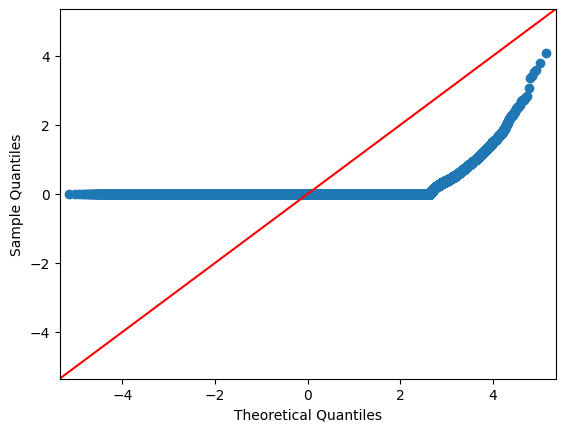

In [40]:
preds = model.predict(translated_df[numeric_predictors])
sm.qqplot(preds, line='45')
plt.show()

/Users/matthewbone/Documents/Coding/VSCode/twitterChambers/twitEnv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'true value')

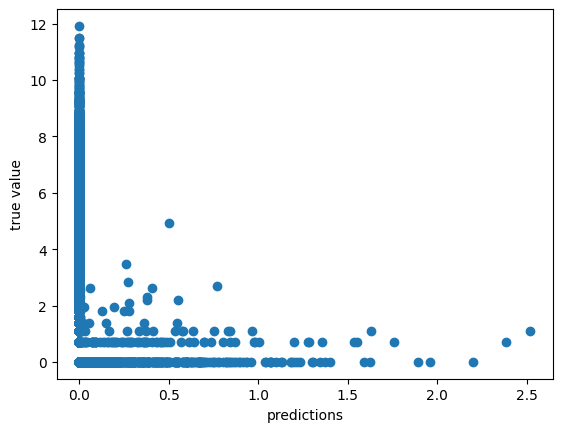

In [37]:
plt.scatter(preds, np.log(translated_df['retweets']))
plt.xlabel('predictions')
plt.ylabel('true value')

In [57]:
display(nb_model.aic)
display(pois_model.aic)
display(ols_model.aic)

12572505.375581509

66924295.14265388

94687749.214773